In [1]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

Added /nfs/home/cybai/PyTorch-StudioGAN/src to path
Added /nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch to path
Added /nfs/home/cybai/PyTorch-StudioGAN/data-copying to path
Added /nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10 to path


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

from run_infos import runs

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cpu'# 'cuda'
torch.backends.cudnn.benchmark = True

In [4]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [8]:
feats = {}
labels = {}
for dset_name, dl in ref_dls.items():
    (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    feats[dset_name] = feats_
    labels[dset_name] = ys_
    print(dset_name, feats_.shape, ys_.shape)

cifar10_1 (2000, 2048) (2000,)
cifar10_train (50000, 2048) (50000,)
cifar10_test (10000, 2048) (10000,)
cifair10 (10000, 2048) (10000,)


In [ ]:
# SAGAN experiments (run in cl8)
samplers = {mrt: [misc.wrapper_best(runname, 'CIFAR10', device=device) for runname in runs['CIFAR10']['diffaug'][mrt]]
            for mrt in [0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16]}

In [16]:
(gen_xs, gen_ys), gen_feats, gen_logits = misc.project(samplers[0][0], proj_model, n_samples=10000)

In [17]:
gen_xs.shape, gen_ys.shape, gen_feats.shape, gen_logits.shape

((10000, 3, 32, 32), (10000,), (10000, 2048), (10000, 1000))

In [19]:
nnds = misc.calculate_knnd_numpy(gen_feats, feats['cifar10_train'], return_indices=False)
nnds.shape

(10000,)

(975,)


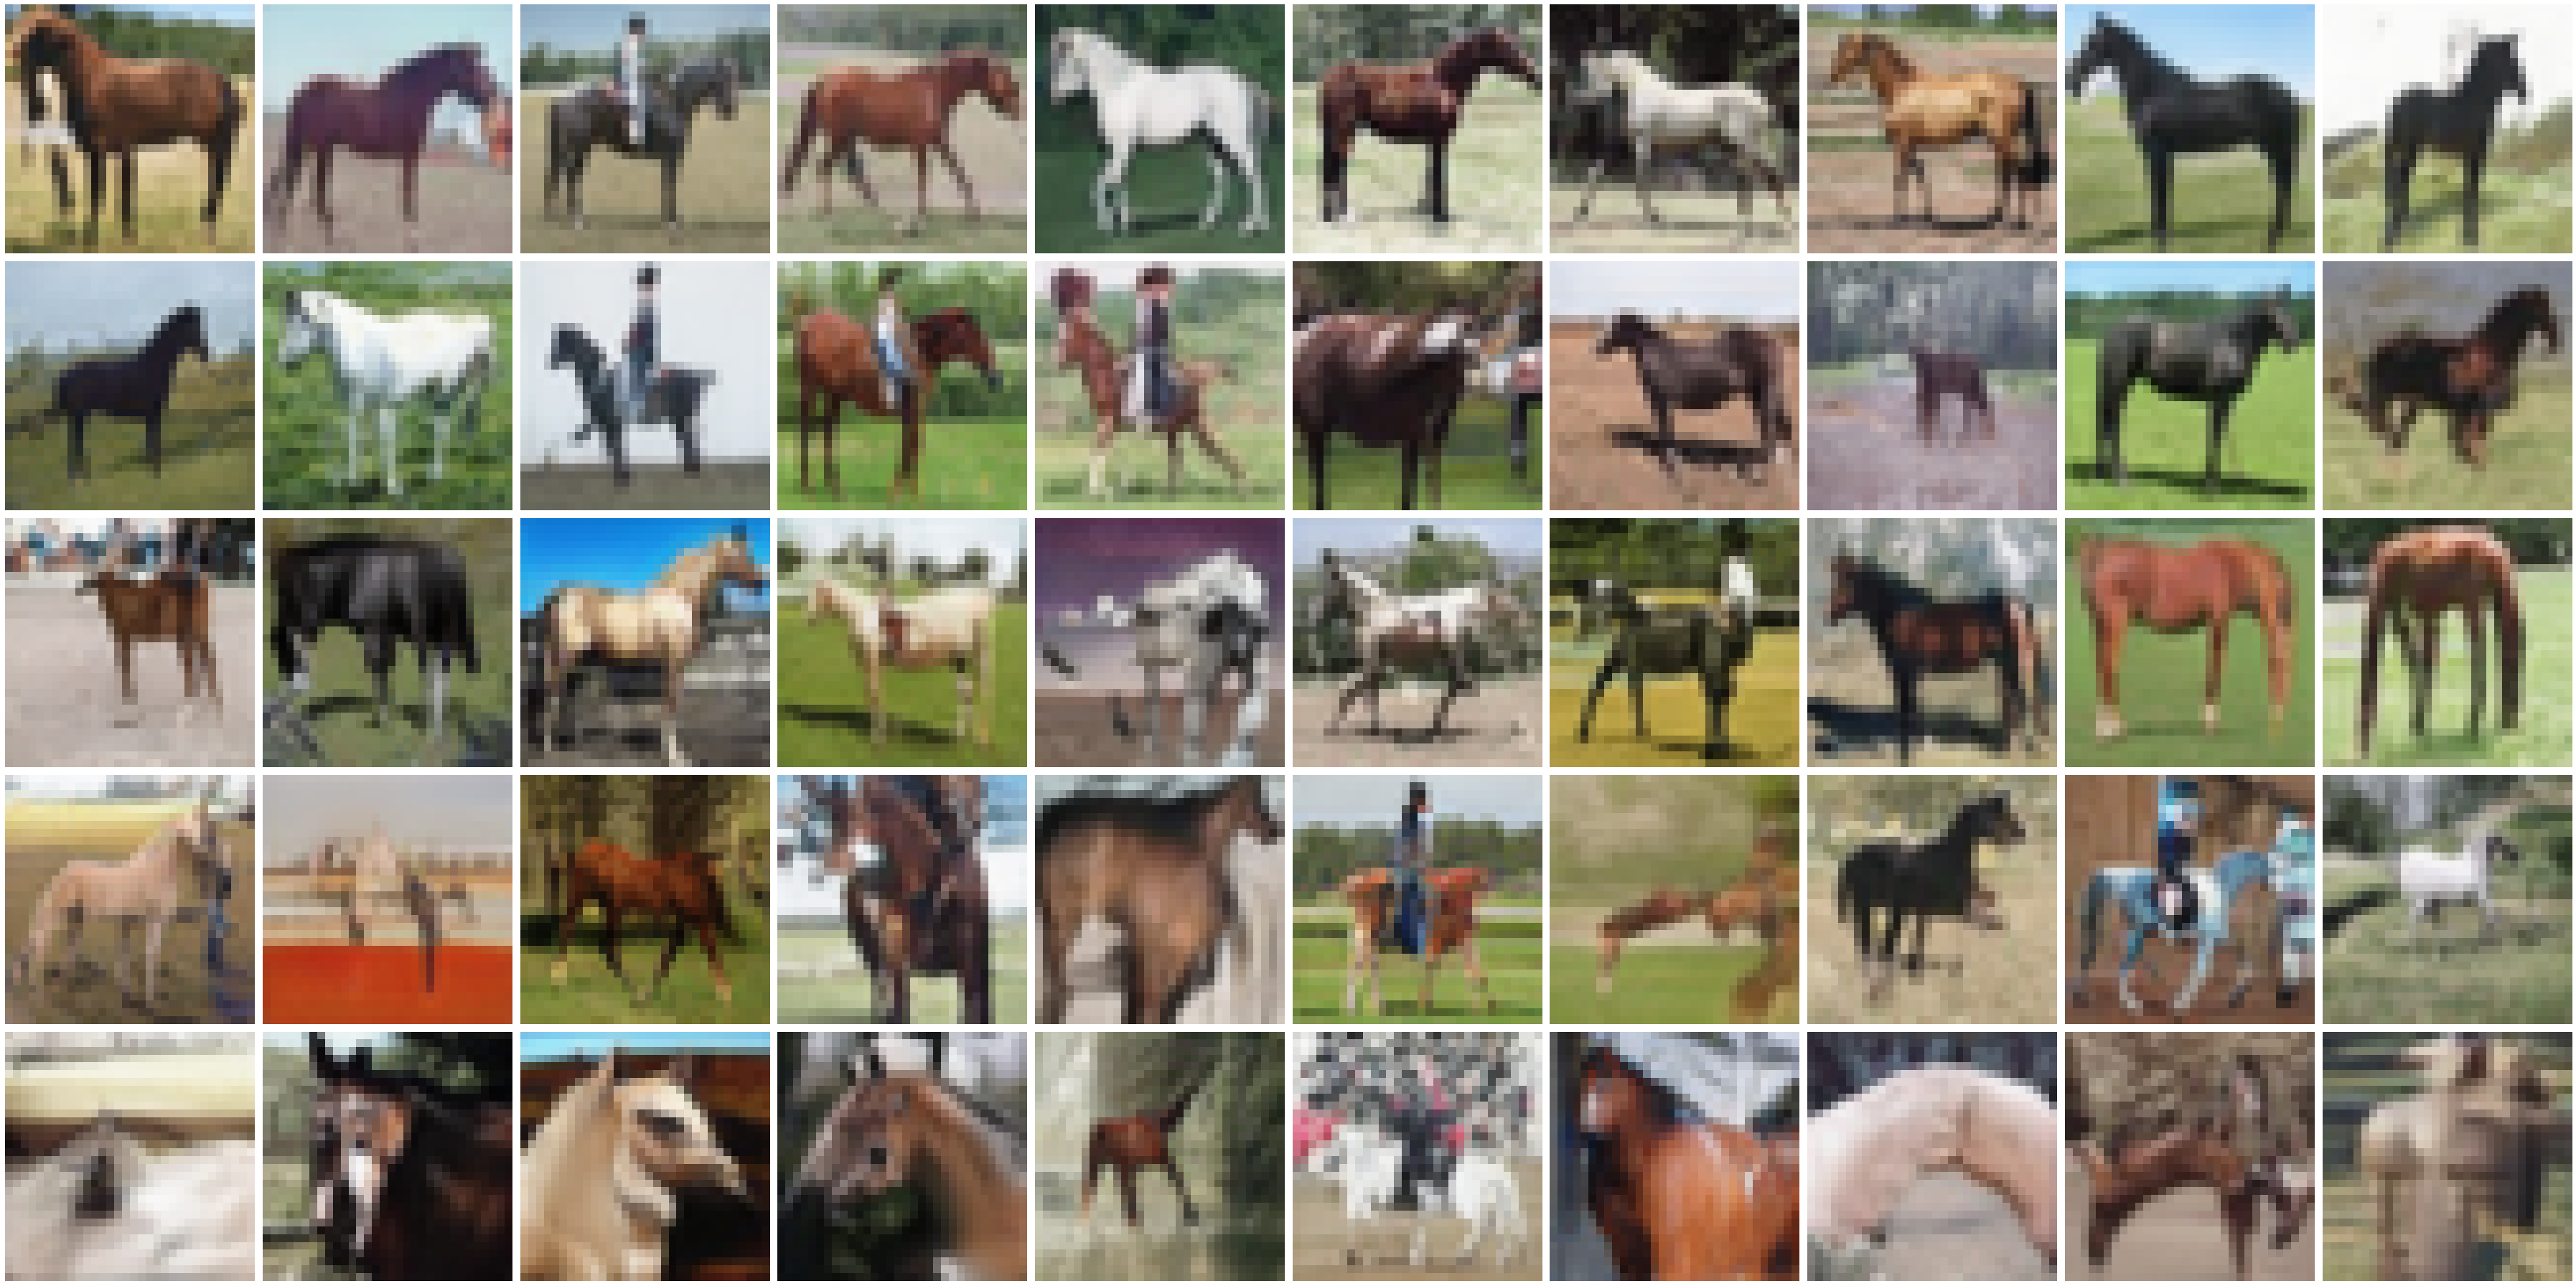

In [35]:
target_class = 'horse'
n_bins = 5
samples_per_bin = 10
img_width = 5

class_mask = gen_ys == cifar10_classnames.index(target_class)
class_xs, class_nnds = gen_xs[class_mask], nnds[class_mask]
bin_edges = np.quantile(class_nnds, np.arange(0, 1 + 1. / n_bins, 1. / n_bins))# np.histogram_bin_edges(class_nnds, bins=n_bins)
hist_indices = np.digitize(class_nnds, bin_edges)
print(hist_indices.shape)

fig, axs = plt.subplots(len(bin_edges) - 1, samples_per_bin, 
                        figsize=(samples_per_bin * img_width, 
                                 (len(bin_edges) - 1) * img_width))


for bin_idx, axs_ in zip(range(len(bin_edges) - 1), axs):
    filtered_xs = class_xs[hist_indices == bin_idx + 1]
    for filtered_x, ax in zip(filtered_xs, axs_):
        filtered_x = (np.transpose(filtered_x, (1, 2, 0)) + 1.) / 2.
        ax.imshow(filtered_x)
        ax.set_axis_off()
fig.tight_layout()
plt.savefig(f'quality_memorization_tradeoff({target_class}).pdf', bbox_inches='tight')

(975,)


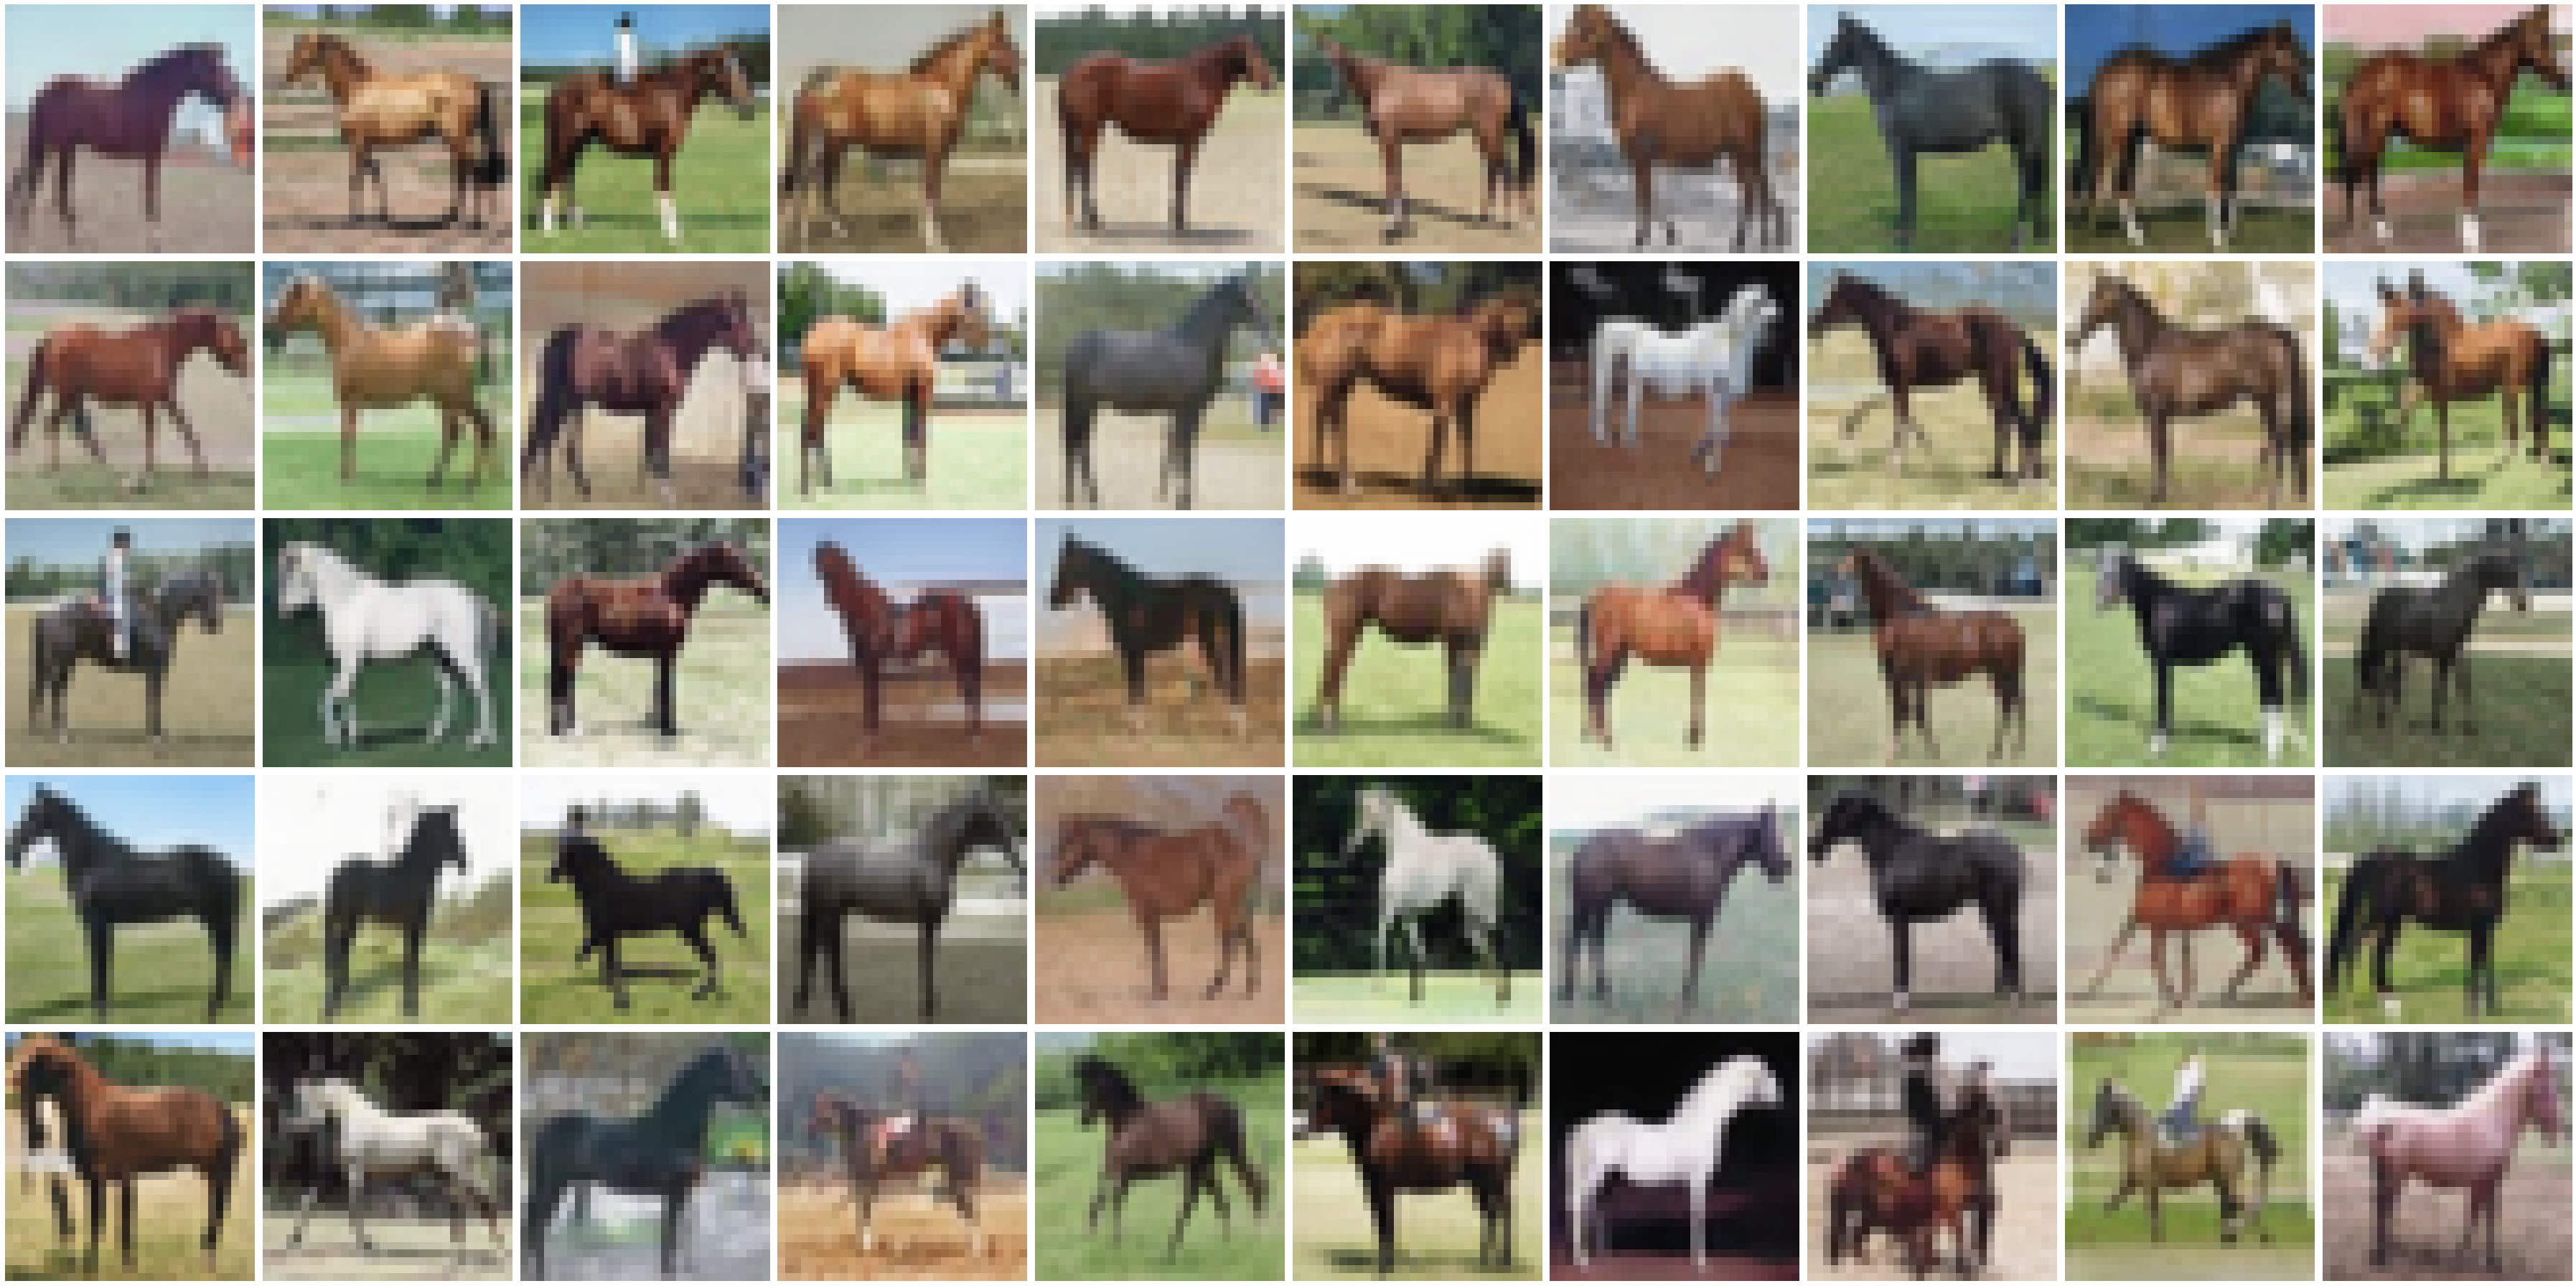

In [37]:
target_class = 'horse'
n_bins = 5
samples_per_bin = 10
img_width = 5

class_mask = gen_ys == cifar10_classnames.index(target_class)
class_xs, class_nnds = gen_xs[class_mask], nnds[class_mask]
bin_edges = np.quantile(class_nnds, np.arange(0, 0.2 + 0.2 / n_bins, 0.2 / n_bins))# np.histogram_bin_edges(class_nnds, bins=n_bins)
hist_indices = np.digitize(class_nnds, bin_edges)
print(hist_indices.shape)

fig, axs = plt.subplots(len(bin_edges) - 1, samples_per_bin, 
                        figsize=(samples_per_bin * img_width, 
                                 (len(bin_edges) - 1) * img_width))


for bin_idx, axs_ in zip(range(len(bin_edges) - 1), axs):
    filtered_xs = class_xs[hist_indices == bin_idx + 1]
    for filtered_x, ax in zip(filtered_xs, axs_):
        filtered_x = (np.transpose(filtered_x, (1, 2, 0)) + 1.) / 2.
        ax.imshow(filtered_x)
        ax.set_axis_off()
fig.tight_layout()
plt.savefig(f'quality_memorization_tradeoff_refined({target_class}).pdf', bbox_inches='tight')

### Visualize samples

In [8]:
%ls /tmp2/cybai

celebahq-modified/  studiogan/


In [14]:
runs['CIFAR10']['sagan']

{0.0: ['SAGAN-train-2021_03_04_15_20_57',
  'SAGAN-train-2021_03_09_00_54_36',
  'SAGAN-train-2021_03_10_10_00_29',
  'SAGAN-train-2021_03_17_13_42_52'],
 0.1: ['SAGAN-train-2021_03_06_00_44_13',
  'SAGAN-train-2021_03_09_00_57_09',
  'SAGAN-train-2021_03_11_10_38_54',
  'SAGAN-train-2021_03_18_13_59_54'],
 0.12: ['SAGAN-train-2021_03_06_00_46_59',
  'SAGAN-train-2021_03_09_01_00_30',
  'SAGAN-train-2021_03_12_11_16_43',
  'SAGAN-train-2021_03_28_13_20_51'],
 0.13: ['SAGAN-train-2021_03_06_00_48_39',
  'SAGAN-train-2021_03_09_02_08_08',
  'SAGAN-train-2021_03_13_11_47_27',
  'SAGAN-train-2021_03_28_13_21_53'],
 0.14: ['SAGAN-train-2021_03_06_00_50_43',
  'SAGAN-train-2021_03_27_11_48_10',
  'SAGAN-train-2021_03_14_12_23_07',
  'SAGAN-train-2021_03_28_13_30_23'],
 0.15: ['SAGAN-train-2021_03_06_00_54_20',
  'SAGAN-train-2021_03_27_11_51_51',
  'SAGAN-train-2021_03_15_12_50_35',
  'SAGAN-train-2021_04_03_16_07_22'],
 0.16: ['SAGAN-train-2021_03_06_00_57_47',
  'SAGAN-train-2021_03_27_11_

In [9]:
no_mr_sampler = misc.wrapper_best(runs['CIFAR10']['sagan'][0.0][0], 'CIFAR10', device=device, sample_mode=0)
mr_sampler = misc.wrapper_best(runs['CIFAR10']['sagan'][0.14][0], 'CIFAR10', device=device, sample_mode=0)

In [10]:
(gen_xs, gen_ys), gen_feats, gen_logits = misc.project(no_mr_sampler, proj_model, n_samples=64)
(mr_gen_xs, mr_gen_ys), mr_gen_feats, mr_gen_logits = misc.project(mr_sampler, proj_model, n_samples=64)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
gen_xs.shape